In [13]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

# Add the 'src' folder to the path
sys.path.insert(0, os.path.abspath('../src'))

# --- Import our new tools ---
from data_fetcher.yfinance_fetcher import fetch_data
from calibration.gbm_calibrator import GbmCalibrator
from calibration.merton_calibrator import MertonCalibrator

# --- Import our old model for validation ---
from models.gbm import GeometricBrownianMotion

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
print("All modules imported successfully.")

All modules imported successfully.


/media/harsh-vardhan-gupta/New Volume/Placement Prep/BTP/src/data_fetcher/yfinance_fetcher.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Fetching ^INDIAVIX data from 2015-01-01 to 2024-12-31...
Data fetched successfully. 2450 data points.


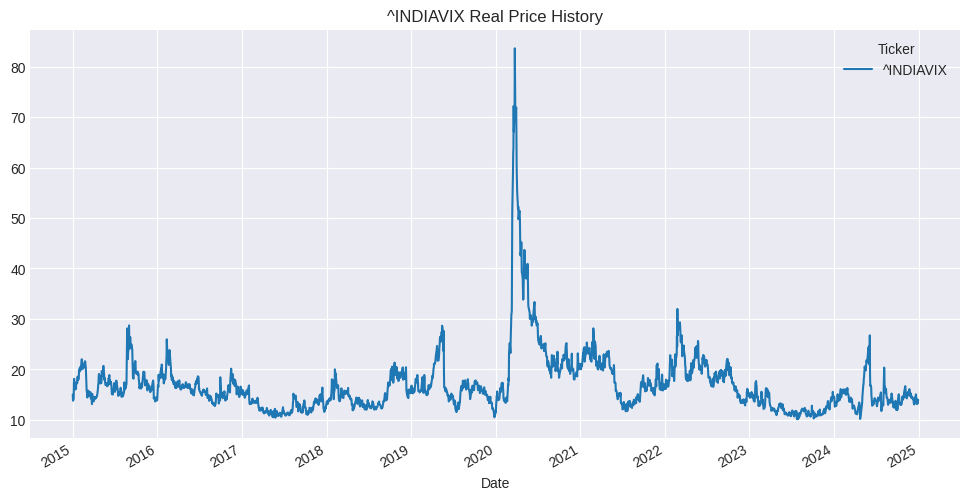

In [14]:
# Cell 2: Fetch Real Data
ticker = '^INDIAVIX' # S&P 500 ETF
start = '2015-01-01'
end = '2024-12-31' # Use a real end date

print(f"Fetching {ticker} data from {start} to {end}...")
real_data = fetch_data(ticker, start, end)

if real_data is not None:
    print(f"Data fetched successfully. {len(real_data)} data points.")
    real_data.plot(title=f"{ticker} Real Price History", figsize=(12, 6))
    plt.show()
else:
    print("Failed to fetch data.")

In [15]:
# Create the calibrator instance
# We use dt=1/252 since it's daily data
gbm_cal = GbmCalibrator(dt=1/252)
merton_cal = MertonCalibrator(dt=1/252)
# Fit the model to the data
# print(real_data)
calibrated_params = gbm_cal.fit(real_data[ticker])
merton_params = merton_cal.fit(real_data[ticker])
print("--- Calibration Complete ---")
print(f"Calibrated Parameters(GBM):\n{calibrated_params}")
print(f"Calibrated Parameters(Merton):\n{merton_params}")

--- Calibration Complete ---
Calibrated Parameters(GBM):
{'mu': np.float64(0.3329470211060503), 'sigma': np.float64(0.8251941009671122), 'S0': np.float64(15.029999732971191)}
Calibrated Parameters(Merton):
{'mu': np.float64(0.3285339096892307), 'sigma': np.float64(0.5661767886774446), 'lambda_j': np.float64(43.79809679208267), 'mu_j': np.float64(0.020928825850555926), 'sigma_j': np.float64(0.08610685724530719), 'S0': np.float64(15.029999732971191)}


In [16]:
# Cell 4: Check Model Fit (AIC/BIC)
# This checks if the new base class methods are working
try:
    print(f"\n--- Model Fit Statistics ---")
    print(f"Log-Likelihood: {gbm_cal.get_log_likelihood():.2f}")
    print(f"Num. Parameters: {gbm_cal.n_params}")
    print(f"Num. Observations: {gbm_cal.n_obs}")
    print(f"AIC: {gbm_cal.get_aic():.2f}")
    print(f"BIC: {gbm_cal.get_bic():.2f}")
except Exception as e:
    print(f"Error getting stats: {e}")

try:
    print(f"\n--- Model Fit Statistics ---")
    print(f"Log-Likelihood: {merton_cal.get_log_likelihood():.2f}")
    print(f"Num. Parameters: {merton_cal.n_params}")
    print(f"Num. Observations: {merton_cal.n_obs}")
    print(f"AIC: {merton_cal.get_aic():.2f}")
    print(f"BIC: {merton_cal.get_bic():.2f}")
except Exception as e:
    print(f"Error getting stats: {e}")


--- Model Fit Statistics ---
Log-Likelihood: 3766.85
Num. Parameters: 2
Num. Observations: 2449
AIC: -7529.70
BIC: -7518.09

--- Model Fit Statistics ---
Log-Likelihood: 4018.93
Num. Parameters: 5
Num. Observations: 2449
AIC: -8027.86
BIC: -7998.84



Running validation simulation...


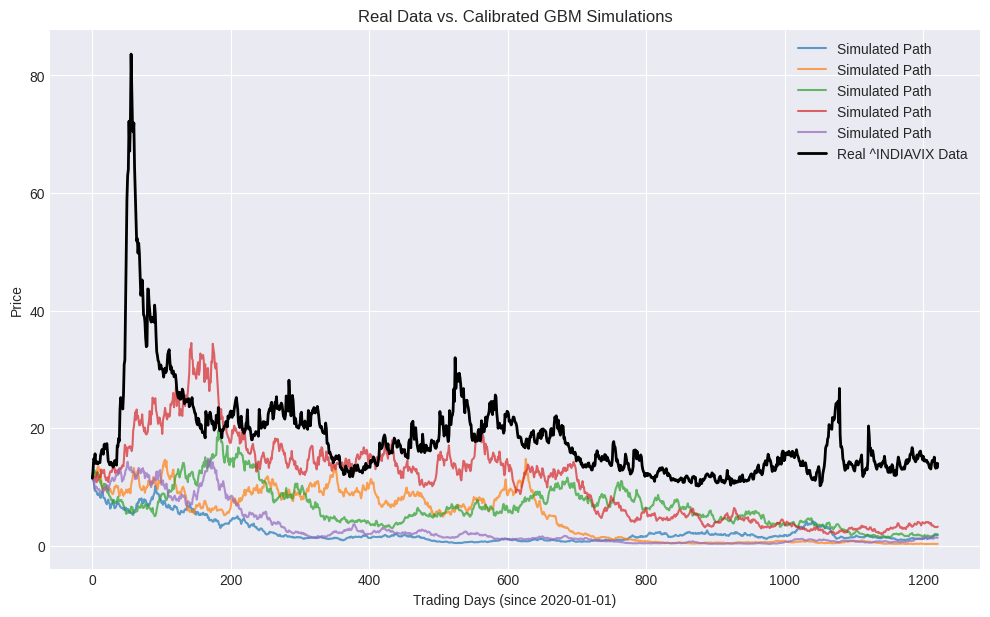

In [5]:
# Cell 5: Validation - Simulate using these params
print("\nRunning validation simulation...")

# 1. Create a GBM model instance using the *real* params
gbm_real = GeometricBrownianMotion(**calibrated_params)

# 2. Set simulation time to match the real data
T_real = gbm_cal.n_obs * gbm_cal.dt # (e.g., 2518 * 1/252 = ~10 years)
dt = gbm_cal.dt
n_paths = 5 # Number of simulations to show

sim_paths = gbm_real.simulate(T_real, dt, n_paths)

# 3. Plot and compare
plt.figure(figsize=(12, 7))

# Plot simulated paths
plt.plot(sim_paths, alpha=0.7, label="Simulated Path")

# Plot the real data on top
# We need to reset the index to match the 0-based sim
real_data_plot = real_data.reset_index(drop=True)
plt.plot(
    real_data_plot, 
    color='black', 
    linewidth=2.0, 
    label=f"Real {ticker} Data"
)

plt.title(f"Real Data vs. Calibrated GBM Simulations")
plt.xlabel(f"Trading Days (since {start})")
plt.ylabel("Price")
plt.legend()
plt.show()